In [28]:
import sklearn
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf


Wine data set

https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-dataset

In [29]:
from sklearn import datasets

wine = datasets.load_wine(as_frame=True)
X = wine.data
y = wine.target

In [25]:
X

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [30]:
X.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


array([[<AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'malic_acid'}>,
        <AxesSubplot:title={'center':'ash'}>,
        <AxesSubplot:title={'center':'alcalinity_of_ash'}>],
       [<AxesSubplot:title={'center':'magnesium'}>,
        <AxesSubplot:title={'center':'total_phenols'}>,
        <AxesSubplot:title={'center':'flavanoids'}>,
        <AxesSubplot:title={'center':'nonflavanoid_phenols'}>],
       [<AxesSubplot:title={'center':'proanthocyanins'}>,
        <AxesSubplot:title={'center':'color_intensity'}>,
        <AxesSubplot:title={'center':'hue'}>,
        <AxesSubplot:title={'center':'od280/od315_of_diluted_wines'}>],
       [<AxesSubplot:title={'center':'proline'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

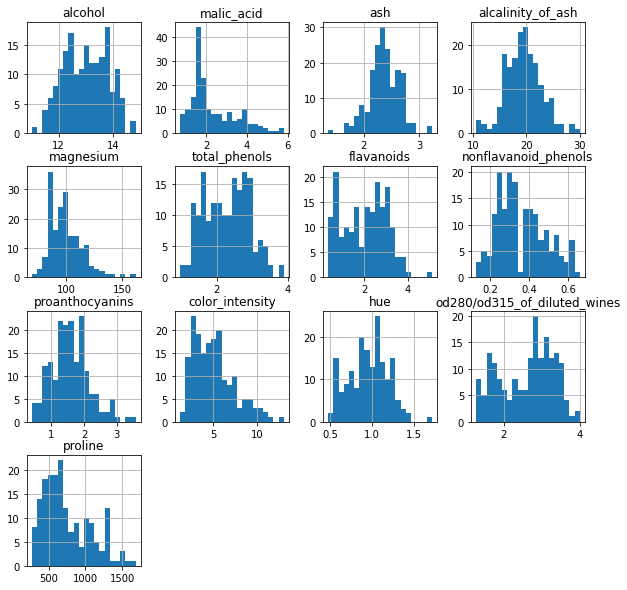

In [40]:
X.hist(bins=20, figsize=(10,10), layout=(4,4))

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Softmax Regression With SKLearn

In [42]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    multi_class='multinomial',
    tol=1e-4,
    solver='newton-cg',
    max_iter=1000,
    verbose=1,
    penalty='l2'
).fit(X_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [43]:
from sklearn.metrics import log_loss
import math

y_prob = lr_model.predict_proba(X)
mlogloss = log_loss(y, y_prob)

print("Logloss: {}".format(mlogloss))


Logloss: 0.03898258791110504


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
CATEGORIES = [0, 1, 2]


In [45]:
y_hat = lr_model.predict(X)

In [46]:
print(classification_report(y_true=y, y_pred=y_hat, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9831    0.9915        59
           1     0.9861    1.0000    0.9930        71
           2     1.0000    1.0000    1.0000        48

    accuracy                         0.9944       178
   macro avg     0.9954    0.9944    0.9948       178
weighted avg     0.9945    0.9944    0.9944       178



In [47]:
cm = confusion_matrix(y_true=y, y_pred=y_hat, labels=CATEGORIES)

In [48]:
cm

array([[58,  1,  0],
       [ 0, 71,  0],
       [ 0,  0, 48]])

# Gradient Boost Tree with Xgboost

In [52]:
from xgboost import XGBClassifier

my_model = XGBClassifier(
    base_score=0.5,
    objective='multi:softmax',
    num_class=3,
    
    gamma=0,
    max_depth=3,
    learning_rate=0.3, 
    min_child_weight=1,
    n_estimators=100,
    subsample=0.8,
    colsample_bynode=1,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1,

    random_state=0,
    booster='gbtree',
    tree_method='hist',
    seed=1234,
    missing=-1,
    verbosity=1
)

print(my_model.get_xgb_params())

trained = my_model.fit(
    X_train, y_train, early_stopping_rounds=5,
    # the last metric is used for early stopping
    eval_metric=["merror", "mlogloss"],
    eval_set=[(X_train, y_train), (X_validation, y_validation)], verbose=True)


{'objective': 'multi:softmax', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'gpu_id': None, 'interaction_constraints': None, 'learning_rate': 0.3, 'max_delta_step': None, 'max_depth': 3, 'min_child_weight': 1, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': 1, 'num_class': 3, 'seed': 1234}
[0]	validation_0-merror:0.02113	validation_0-mlogloss:0.75256	validation_1-merror:0.05556	validation_1-mlogloss:0.76980
[1]	validation_0-merror:0.00704	validation_0-mlogloss:0.55111	validation_1-merror:0.00000	validation_1-mlogloss:0.55639
[2]	validation_0-merror:0.01409	validation_0-mlogloss:0.41327	validation_1-merror:0.00000	validation_1-mlogloss:0.43342
[3]	validation_0-merror:0.00704	validation_0-mlogloss:0.31624	validation_1-merror

In [57]:
y_hat = trained.predict(X)
print(classification_report(y_true=y, y_pred=y_hat, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        59
           1     1.0000    1.0000    1.0000        71
           2     1.0000    1.0000    1.0000        48

    accuracy                         1.0000       178
   macro avg     1.0000    1.0000    1.0000       178
weighted avg     1.0000    1.0000    1.0000       178



In [58]:
cm = confusion_matrix(y_true=y, y_pred=y_hat, labels=CATEGORIES)

array([[59,  0,  0],
       [ 0, 71,  0],
       [ 0,  0, 48]])

# Softmax Regression In Neural Network Style

In [59]:
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseCategoricalAccuracy



In [60]:
def build_softmax_regression():
    inputs = Input(shape=(13,))
    l = inputs    
    l = Dense(3, activation="softmax", name='fc')(l)
    my_model = Model(inputs=inputs, outputs=l)
    print(my_model.summary())
    return my_model

def model_train(X_train, y_train, X_val, y_val, model):
    print(model.summary())
    early_stop = EarlyStopping(
        monitor="val_loss", min_delta=1e-5, patience=3,
        verbose=0, mode="auto", baseline=None, restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=1e-4)

    callbacks_list = [early_stop, reduce_lr]

    # optimizer: gradient descent implementation
    adam_wn = Adam(learning_rate=0.1)
    
    # compile model with loss and optimizer; loss function needs to match the intention and the output of the last layer
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam_wn,
        metrics=[SparseCategoricalAccuracy()]
    )
    
    # kick off model training
    return model.fit(
        x=X_train, y=y_train, validation_data=(X_val, y_val), batch_size=178,
        epochs=1000, verbose=1, shuffle=True,
        callbacks=callbacks_list)


In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)

In [65]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [66]:

my_tf_model = build_softmax_regression()

model_train(X_train_scaled, y_train, X_validation_scaled, y_validation, my_tf_model)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
fc (Dense)                   (None, 3)                 42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
fc (Dense)                   (None, 3)                 42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1/1 [======================

Epoch 40/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0164 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0100 - val_sparse_categorical_accuracy: 1.0000
Epoch 41/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0161 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0098 - val_sparse_categorical_accuracy: 1.0000
Epoch 42/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0158 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0097 - val_sparse_categorical_accuracy: 1.0000
Epoch 43/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0155 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0096 - val_sparse_categorical_accuracy: 1.0000
Epoch 44/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0152 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0096 - val_sparse_categorical_accuracy: 1.0000
Epoch 45/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0149 - sparse_categorica